In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import os
import time
from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import hdbscan

# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [2]:
def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list: List[str]):
    """ Computes ecfp descriptors """
    
    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)
    
    return None

def plot_global_embeddings_with_clusters(df: pd.DataFrame,
                          x_col: str,
                          y_col: str,
                          cluster_col: str,
                          title: str = "",
                          x_lim = None,
                          y_lim = None):
    """ Plots data colored by soft HDBSCAN clusters
    
    If the cluster of a compund is not specified (cluster < 0), it will be
    plotted gray, otherwise it will be colored by the cluster value.
    """
    clustered = df[cluster_col].values >= 0
    
    plt.figure(figsize=(10,8))
    ax=sns.scatterplot(data=df.iloc[~clustered],
                    x=x_col,
                    y=y_col,
                    color=(0.5, 0.5, 0.5),
                    s=10,
                    alpha=0.1)
    sns.scatterplot(data=df.iloc[clustered],
                    x=x_col,
                    y=y_col,
                    hue=cluster_col,
                    alpha=0.5,
                    palette="nipy_spectral",
                    ax=ax)
    if x_lim:
      ax.set_xlim(x_lim)
    if y_lim:
      ax.set_ylim(y_lim)

    sm = plt.cm.ScalarMappable(cmap="nipy_spectral")
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm, label="Global Cluster")
  
    plt.title(title)
    plt.show()

In [3]:
# Read in data from MoleculeNet
bbbp = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv")

# Clean up columnn names so they are easier to interpret
bbbp = bbbp[["smiles", "p_np", "name"]].reset_index(drop=True).rename({"p_np": "permeable"}, axis=1)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
bbbp["smiles"] = bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna()

print(bbbp)

                                                 smiles  permeable  \
0                           CC(C)NCC(O)COc1cccc2ccccc12          1   
1                CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1          1   
2      CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23          1   
3                        CC(=O)NCCCOc1cccc(CN2CCCCC2)c1          1   
4     Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...          1   
...                                                 ...        ...   
2045     O=c1[nH]c2cc(Cl)c(Cl)c([N+](=O)[O-])c2[nH]c1=O          1   
2046  C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc...          1   
2047        CC(Cc1ccccc1)n1cc([N-]C(=O)Nc2ccccc2)[o+]n1          1   
2048  CCc1c(C)[n+]([NH-])c(-c2ccc(OC)c(OC)c2)c2cc(OC...          1   
2049  [N-]=[N+]=NCC(=O)N[C@H](CO)[C@H](O)c1ccc([N+](...          1   

                                   name  
0                            Propanolol  
1                  Terbutylchlorambucil  
2                                

In [4]:
# Compute desrciptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Only keep those that sucessfully featurized
bbbp = bbbp.iloc[keep_idx]

In [5]:
##### UMAP Embedding

#%%time
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(ecfp_descriptors)
bbbp["UMAP_0"], bbbp["UMAP_1"] = X_umap[:,0], X_umap[:,1]

##### PCA Embedding

#%%time
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors)
bbbp["PCA_0"], bbbp["PCA_1"] = X_pca[:,0], X_pca[:,1]

##### tSNE Embedding

#%%time
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(ecfp_descriptors)
bbbp["TNSE_0"], bbbp["TNSE_1"] = X_tsne[:,0], X_tsne[:,1]

C:\Users\peter\anaconda3\envs\rdkit\lib\site-packages\umap\umap_.py:1804: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
C:\Users\peter\anaconda3\envs\rdkit\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\peter\anaconda3\envs\rdkit\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


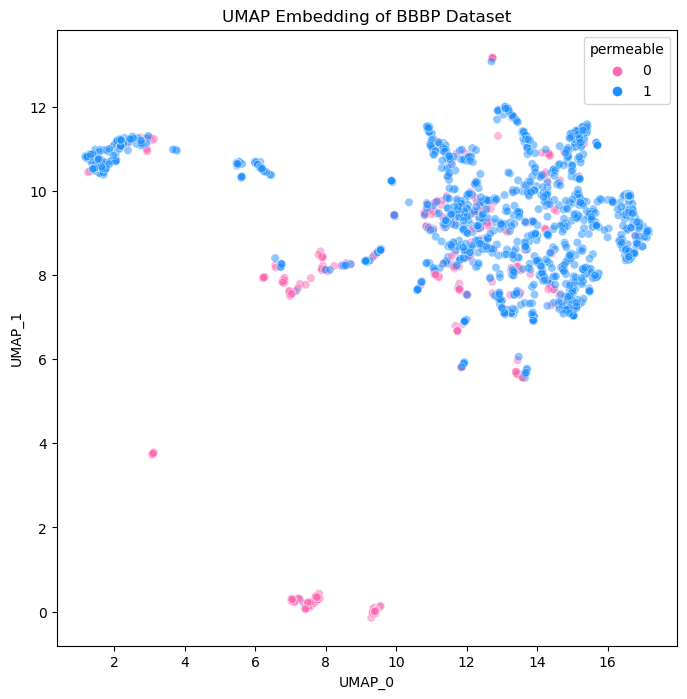

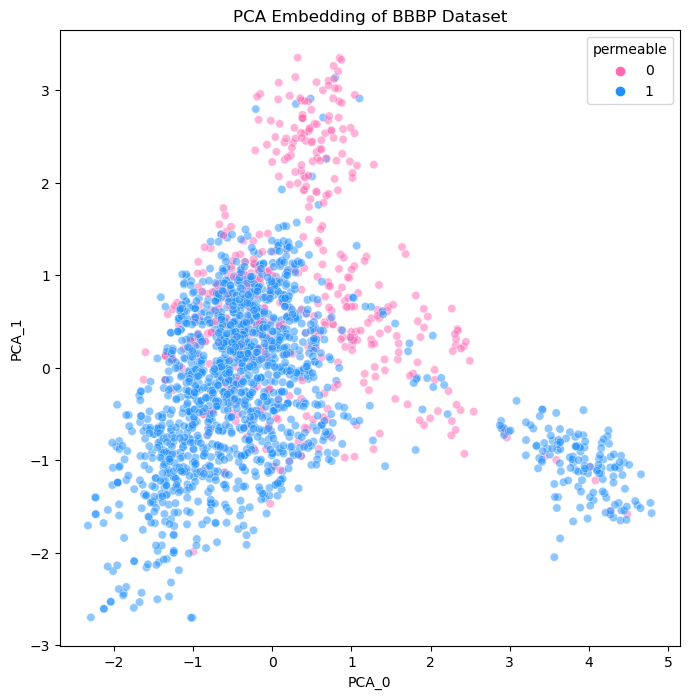

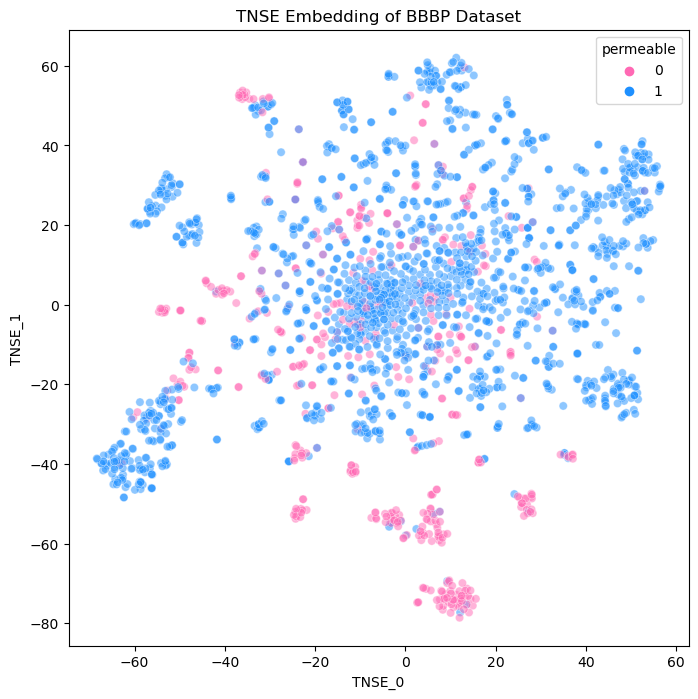

In [6]:
palette = sns.color_palette(["hotpink", "dodgerblue"])
for method in ["UMAP", "PCA", "TNSE"]:
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=bbbp,
                    x=f"{method}_0",
                    y=f"{method}_1",
                    hue="permeable",
                    alpha=0.5,
                    palette=palette)
    plt.title(f"{method} Embedding of BBBP Dataset")
    plt.show()
